# Kaggle比赛，预测房价

## 1. 下载和缓存数据集

In [192]:
import hashlib
import os
import tarfile
import zipfile
import requests


DATA_HUB = dict()
DATA_URL = 'http://d2l-data.s3-accelerate.amazonaws.com/'


'''下载数据集，将数据集缓存在本地目录，默认../data/
返回下载文件名称，如果以存在文件，将其sha-1与存储在DATA_HUB中的匹配
'''
def download(name, cache_dir=os.path.join('..', 'data')):  #@save
    """下载一个DATA_HUB中的文件，返回本地文件名"""
    assert name in DATA_HUB, f"{name} 不存在于 {DATA_HUB}"
    url, sha1_hash = DATA_HUB[name]
    os.makedirs(cache_dir, exist_ok=True)
    fname = os.path.join(cache_dir, url.split('/')[-1])
    if os.path.exists(fname):
        sha1 = hashlib.sha1()
        with open(fname, 'rb') as f:
            while True:
                data = f.read(1048576)
                if not data:
                    break
                sha1.update(data)
        if sha1.hexdigest() == sha1_hash:
            return fname  # 命中缓存
    print(f'正在从{url}下载{fname}...')
    r = requests.get(url, stream=True, verify=True)
    with open(fname, 'wb') as f:
        f.write(r.content)
    return fname

def download_extract(name, folder=None):  #@save
    """下载并解压zip/tar文件"""
    fname = download(name)
    base_dir = os.path.dirname(fname)
    data_dir, ext = os.path.splitext(fname)
    if ext == '.zip':
        fp = zipfile.ZipFile(fname, 'r')
    elif ext in ('.tar', '.gz'):
        fp = tarfile.open(fname, 'r')
    else:
        assert False, '只有zip/tar文件可以被解压缩'
    fp.extractall(base_dir)
    return os.path.join(base_dir, folder) if folder else data_dir

def download_all():  #@save
    """下载DATA_HUB中的所有文件"""
    for name in DATA_HUB:
        download(name)


## 2. Kaggle

https://www.kaggle.com/c/house-prices-advanced-regression-techniques

## 3. 访问和读取数据集
使用pandas读入并处理数据

In [193]:
%matplotlib inline
import numpy as np
import pandas as pd
import torch
from torch import nn
from d2l import torch as d2l

In [194]:
'''使用上面定义的脚本下载数据集'''
DATA_HUB['kaggle_house_train'] = (  #@save
    DATA_URL + 'kaggle_house_pred_train.csv',
    '585e9cc93e70b39160e7921475f9bcd7d31219ce')

DATA_HUB['kaggle_house_test'] = (  #@save
    DATA_URL + 'kaggle_house_pred_test.csv',
    'fa19780a7b011d9b009e8bff8e99922a8ee2eb90')

In [195]:
'''使用pandas分别加载包含训练数据集和测试集的两个csv文件'''
train_data = pd.read_csv(download('kaggle_house_train'))
test_data = pd.read_csv(download('kaggle_house_test'))

In [196]:
'''查看数据形状'''
print(train_data.shape)
print(test_data.shape)

(1460, 81)
(1459, 80)


In [197]:
'''将train_data中的id信息删除
将训练集和测试集的数据连接到一起，除去id和label
'''
all_features = pd.concat([train_data.iloc[:, 1 : -1], test_data.iloc[:, 1 : ]])
print(all_features.shape)

(2919, 79)


## 4. 数据预处理
1. 需要将缺失值替换为相应特征的平均值，然后将所有特征放在同一个尺度上，通过将特征重新缩放到零君之和单位方差来标准化数据
2. $x \leftarrow \frac{x - \mu}{\sigma}$
3. 标准化数据有两个原因：方便优化；不知道哪些特征相关，不想让惩罚分配给一个特殊的系数比分配给其他任何特征的系数更大。

In [198]:
# 若无法获得测试数据，可以根据训练数据计算均值和标准差
numeric_features = all_features.dtypes[all_features.dtypes != 'object'].index
all_features[numeric_features] = all_features[numeric_features].apply(
    lambda x: (x-x.mean()) / (x.std())
)
# 在标准化数据后，所有均值消失，将缺失值设置为0
all_features[numeric_features] = all_features[numeric_features].fillna(0)
all_features

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,0.067320,RL,-0.184443,-0.217841,Pave,NaN,Reg,Lvl,AllPub,Inside,...,-0.285886,-0.063139,NaN,NaN,NaN,-0.089577,-1.551918,0.157619,WD,Normal
1,-0.873466,RL,0.458096,-0.072032,Pave,NaN,Reg,Lvl,AllPub,FR2,...,-0.285886,-0.063139,NaN,NaN,NaN,-0.089577,-0.446848,-0.602858,WD,Normal
2,0.067320,RL,-0.055935,0.137173,Pave,NaN,IR1,Lvl,AllPub,Inside,...,-0.285886,-0.063139,NaN,NaN,NaN,-0.089577,1.026577,0.157619,WD,Normal
3,0.302516,RL,-0.398622,-0.078371,Pave,NaN,IR1,Lvl,AllPub,Corner,...,-0.285886,-0.063139,NaN,NaN,NaN,-0.089577,-1.551918,-1.363335,WD,Abnorml
4,0.067320,RL,0.629439,0.518814,Pave,NaN,IR1,Lvl,AllPub,FR2,...,-0.285886,-0.063139,NaN,NaN,NaN,-0.089577,2.131647,0.157619,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,2.419286,RM,-2.069222,-1.043758,Pave,NaN,Reg,Lvl,AllPub,Inside,...,-0.285886,-0.063139,NaN,NaN,NaN,-0.089577,-0.078492,-1.363335,WD,Normal
1455,2.419286,RM,-2.069222,-1.049083,Pave,NaN,Reg,Lvl,AllPub,Inside,...,-0.285886,-0.063139,NaN,NaN,NaN,-0.089577,-0.815205,-1.363335,WD,Abnorml
1456,-0.873466,RL,3.884968,1.246594,Pave,NaN,Reg,Lvl,AllPub,Inside,...,-0.285886,-0.063139,NaN,NaN,NaN,-0.089577,1.026577,-1.363335,WD,Abnorml
1457,0.655311,RL,-0.312950,0.034599,Pave,NaN,Reg,Lvl,AllPub,Inside,...,-0.285886,-0.063139,NaN,MnPrv,Shed,1.144116,0.289865,-1.363335,WD,Normal


In [199]:
'''接下来处理离散数据'''
# 独热编码
all_features = pd.get_dummies(all_features, dummy_na=True, dtype=int)
all_features.shape
all_features

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,SaleType_Oth,SaleType_WD,SaleType_nan,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,SaleCondition_nan
0,0.067320,-0.184443,-0.217841,0.646073,-0.507197,1.046078,0.896679,0.523038,0.580708,-0.29303,...,0,1,0,0,0,0,0,1,0,0
1,-0.873466,0.458096,-0.072032,-0.063174,2.187904,0.154737,-0.395536,-0.569893,1.177709,-0.29303,...,0,1,0,0,0,0,0,1,0,0
2,0.067320,-0.055935,0.137173,0.646073,-0.507197,0.980053,0.848819,0.333448,0.097840,-0.29303,...,0,1,0,0,0,0,0,1,0,0
3,0.302516,-0.398622,-0.078371,0.646073,-0.507197,-1.859033,-0.682695,-0.569893,-0.494771,-0.29303,...,0,1,0,1,0,0,0,0,0,0
4,0.067320,0.629439,0.518814,1.355319,-0.507197,0.947040,0.753100,1.381770,0.468770,-0.29303,...,0,1,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,2.419286,-2.069222,-1.043758,-1.481667,1.289537,-0.043338,-0.682695,-0.569893,-0.968860,-0.29303,...,0,1,0,0,0,0,0,1,0,0
1455,2.419286,-2.069222,-1.049083,-1.481667,-0.507197,-0.043338,-0.682695,-0.569893,-0.415757,-0.29303,...,0,1,0,1,0,0,0,0,0,0
1456,-0.873466,3.884968,1.246594,-0.772420,1.289537,-0.373465,0.561660,-0.569893,1.717643,-0.29303,...,0,1,0,1,0,0,0,0,0,0
1457,0.655311,-0.312950,0.034599,-0.772420,-0.507197,0.682939,0.370221,-0.569893,-0.229194,-0.29303,...,0,1,0,0,0,0,0,1,0,0


In [200]:
'''从pandas格式中提取numpy格式，转化为张量用于训练
train_features [1460, 330]
test_features [1459, 330]
train_labels [1469, 1]
'''
n_train = train_data.shape[0]
train_features = torch.tensor(all_features[:n_train].values, dtype=torch.float32)
test_features = torch.tensor(all_features[n_train:].values, dtype=torch.float32)
train_labels = torch.tensor(train_data.SalePrice.values.reshape(-1, 1), dtype=torch.float32)

## 5. 训练

In [201]:
'''损失函数不是直接用MSE，而是对数形势的MSE的开方'''
loss = nn.MSELoss()
in_faetures = train_features.shape[1]
'''用线性模型作为baseline模型'''
def get_net():
    net = nn.Sequential(
        nn.Linear(in_faetures, 20),
        nn.ReLU(),
        # nn.Dropout(0.2),
        nn.Linear(20, 1)
    )
    return net

使用预测价格的对数与真实标签的价格的对数之间的均方根误差作为损失函数

$$\sqrt{\frac{1}{n} \sum_{i=1}^{n} (\log y_i - \log \hat{y}_i)^2}
$$

In [202]:
def log_rmse(net, features, labels):
    clipped_preds = torch.clamp(net(features), 1, float('inf')) # 在取对数时，将最小值设置为1
    return torch.sqrt(loss(torch.log(labels), torch.log( clipped_preds))).item()

In [203]:
'''定义训练过程，使用adam优化器，不是SGD'''
def train(net, train_features, train_labels, test_features, test_labels,
          num_epochs, learning_rate, weight_decay, batch_size):
    train_ls, test_ls = [], [] # 用于记录每个epoch的训练损失和测试损失
    train_iter = d2l.load_array((train_features, train_labels), batch_size, is_train=True)
    # 使用adam优化算法
    optimizer = torch.optim.Adam(
        net.parameters(), 
        lr = learning_rate, 
        weight_decay = weight_decay
    )
    # 开始训练
    for epoch in range(num_epochs):
        for X, y in train_iter:
            optimizer.zero_grad()
            l = loss(net(X), y) # 损失函数
            l.backward()
            optimizer.step()
        train_ls.append(log_rmse(net, train_features, train_labels))
        if test_labels is not None:
            test_ls.append(log_rmse(net, test_features, test_labels))
    return train_ls, test_ls
        
    


## 6. K折交叉验证

In [204]:
def get_k_fold_data(k, i, X, y):
    # X为features，y为labels
    assert k > 1
    fold_size = X.shape[0] // k # 整除运算，向下取整
    X_train, y_train = None, None
    for j in range(k):
        idx = slice(j * fold_size, (j + 1) * fold_size) # 用于验证的索引切片
        X_part, y_part = X[idx, :], y[idx] # 被切出来的features和labels
        if j == i:
            # 如果j是第i个折叠，将其作为验证集
            X_valid, y_valid = X_part, y_part
        elif X_train is None:
            # 当j不等于i时
            # 或X_train的初始化
            X_train, y_train = X_part, y_part
        else:
            # X_train非空
            X_train = torch.cat([X_train, X_part], 0) # 沿axis=0这个轴拼接
            y_train = torch.cat([y_train, y_part], 0) # 沿axis=0这个轴拼接
    return X_train, y_train, X_valid, y_valid # 将 i 号数据提取出来，放在valid集
        

In [205]:
def k_fold(k, X_train, y_train, num_epochs, learning_rate, weight_decay, batch_size):
    train_l_sum, valid_l_sum = 0, 0
    for i in range(k):
        data = get_k_fold_data(k, i, X_train, y_train)
        net = get_net()
        train_ls, valid_ls = train(net, *data, num_epochs=num_epochs, 
                                   learning_rate=learning_rate, weight_decay=weight_decay, batch_size=batch_size)
        train_l_sum += train_ls[-1]
        valid_l_sum += valid_ls[-1]
        if i == 0:
            d2l.plot(list(range(1, num_epochs + 1)), [train_ls, valid_ls],
                     xlabel='epoch', ylabel='rmse', xlim=[1, num_epochs],
                     legend=['train', 'valid'], yscale='log')
        print(f'折{i + 1}，训练log rmse{float(train_ls[-1]):f}, '
              f'验证log rmse{float(valid_ls[-1]):f}')
    return train_l_sum / k, valid_l_sum / k

## 7. 模型选择

折1，训练log rmse0.138942, 验证log rmse0.144815
折2，训练log rmse0.140671, 验证log rmse0.154743
折3，训练log rmse0.140595, 验证log rmse0.146823
折4，训练log rmse0.149072, 验证log rmse0.146503
折5，训练log rmse0.135234, 验证log rmse0.171316
5-折验证: 平均训练log rmse: 0.140903, 平均验证log rmse: 0.152840


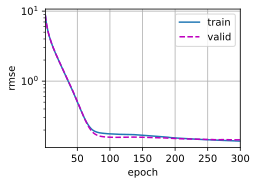

In [213]:
k, num_epochs, lr, weight_decay, batch_size = 5, 300, 0.01, 0, 64
train_l, valid_l = k_fold(k, train_features, train_labels, num_epochs, lr,
                          weight_decay, batch_size)
print(f'{k}-折验证: 平均训练log rmse: {float(train_l):f}, '
      f'平均验证log rmse: {float(valid_l):f}')